## DEMs coregistration demo
### Taking srtm and tandem dems as example.


In [1]:
import numpy as np
import xdem
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap


In [2]:
year='2007'
tile_lon, tile_lat = '95', '30'
path_dem = 'data/dem-data/tandem-x/TDM1_DEM__30_N30E095_V02_C/DEM/TDM1_DEM__30_N30E095_DEM.tif'   # slave dem
path_srtm = 'data/dem-data/srtm-c/tiles/tile_'+tile_lat+'_'+tile_lon+'.tif'         # master dem
path_water_jrc = 'data/water/water-jrc/tiles/tile_'+tile_lat+'_'+tile_lon+'.tif'    # jrc water map for water mask
path_rgi60 = 'data/rgi60/tiles/tile_'+tile_lat+'_'+tile_lon+'.tif'                  # rgi glacier data for glacier mask
path_forest = 'data/globeland30/2010/tiles/tile_'+tile_lat+'_'+tile_lon+'.tif'      # land cover data for forest mask
path_dem_aligned = 'data/aster-stereo/SETP-'+year+'/tiles-dem/tile-'+tile_lat+'-'+tile_lon+'/dems_mosaic_subs_coreg.tif'



### 1. Check dem images, and water/glacier mask images.

srtm: (3600, 3600) dem: (3600, 3600)
(1, 3600, 3600)


Text(0.5, 1.0, 'wat_gla_forest_mask')

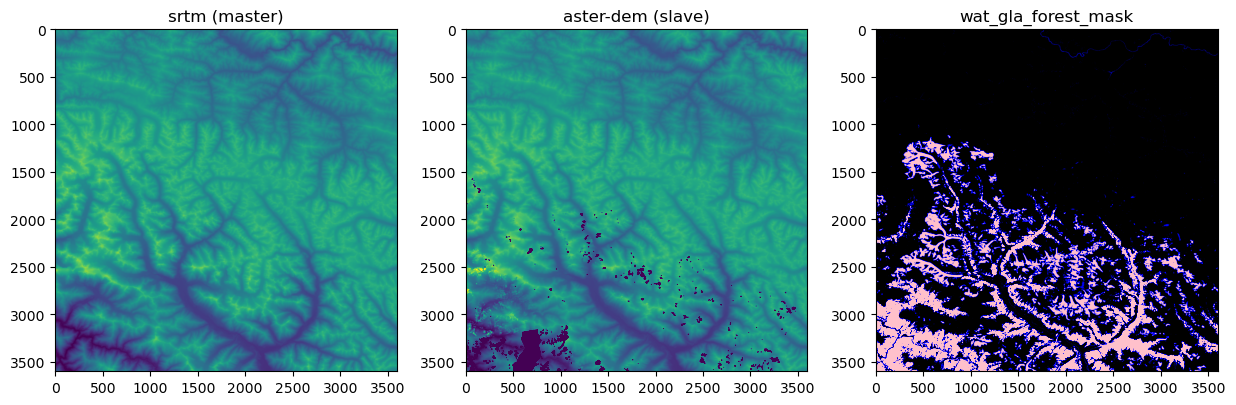

In [3]:
cmap = LinearSegmentedColormap.from_list('linear color', ["Black", 'Blue', 'Pink'])
_, srtm_info = readTiff(path_srtm)    # master dem
### --1. data reading
srtm = xdem.DEM(path_srtm)            # master dem 
dem = xdem.DEM(path_dem).reproject(srtm)      # slave dem
srtm = srtm.reproject(dem)   # ensure the geo-info are completely the same. some bug for the xdem
print('srtm:', srtm.shape, 'dem:', dem.shape)

### --2.water/glacier/forest mask (water:1, glacier:2, other:0)
water_jrc = xdem.DEM(path_water_jrc).reproject(srtm)
rgi60_mask = xdem.DEM(path_rgi60).reproject(srtm)
forest_mask = xdem.DEM(path_forest).reproject(srtm)
forest_mask.data[0] = np.where(forest_mask.data[0]==20, 1, 0) ### extract forest
wat_gla_forest_mask = water_jrc.data[0]+rgi60_mask.data[0]*2 + forest_mask.data[0]*3

### --3. image visualize
print(srtm.data.shape)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(srtm.data[0], vmin=2000, vmax=7000); plt.title('srtm (master)')
plt.subplot(1,3,2); plt.imshow(dem.data[0], vmin=2000, vmax=7000); plt.title('aster-dem (slave)')
plt.subplot(1,3,3); plt.imshow(wat_gla_forest_mask, vmin=0, vmax=2, cmap=cmap); plt.title('wat_gla_forest_mask')
# plt.subplot(2,2,4); plt.imshow(rgi60_mask, vmin=0, vmax=1); plt.title('glacier_mask')


### **2. Co-registration to srtm-c dem by using open-source pybob code.**
##### (Reference: Nuth and Kääb (2011) (https://www.the-cryosphere.net/5/271/2011/tc-5-271-2011.html))


Text(0.5, 1.0, 'water, glacier and forest masked image')

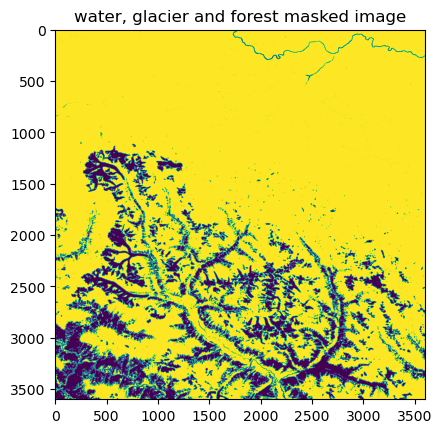

In [4]:
mask_img = np.ma.masked_equal(wat_gla_forest_mask ,0).mask
plt.imshow(mask_img)
plt.title('water, glacier and forest masked image')


In [5]:
nuth_kaab = xdem.coreg.NuthKaab(max_iterations=20, offset_threshold=0.05)  # offset_threshold is the distance threshold
nuth_kaab.fit(reference_dem=srtm, dem_to_be_aligned=dem, inlier_mask=mask_img, verbose=True)
dem_aligned = nuth_kaab.apply(dem)



Running Nuth and Kääb (2011) coregistration
   Calculate slope and aspect
   Statistics on initial dh:
      Median = 1.92 - NMAD = 5.83
   Iteratively estimating horizontal shit:


   Progress:   0%|          | 0/20 [00:01<?, ?it/s]

      #1 - Offset in pixels : (-0.02, -0.04)


   Progress:   5%|▌         | 1/20 [00:02<00:42,  2.23s/it]

      Median = 1.95 - NMAD = 5.72  ==>  Gain = -1.83%


   Progress:   5%|▌         | 1/20 [00:04<00:42,  2.23s/it]

      #2 - Offset in pixels : (-0.00, -0.00)


   Progress:  10%|█         | 2/20 [00:04<00:42,  2.38s/it]

      Median = 1.95 - NMAD = 5.72  ==>  Gain = 0.01%


   Progress:  10%|█         | 2/20 [00:06<00:42,  2.38s/it]

      #3 - Offset in pixels : (-0.00, 0.00)


   Progress:  10%|█         | 2/20 [00:07<01:04,  3.57s/it]


      Median = 1.95 - NMAD = 5.72  ==>  Gain = 0.00%
   Last offset was below the residual offset threshold of 0.05 -> stopping

   Final offset in pixels (east, north) : (-0.025593, -0.039206)
   Statistics on coregistered dh:
      Median = 1.95 - NMAD = 5.72


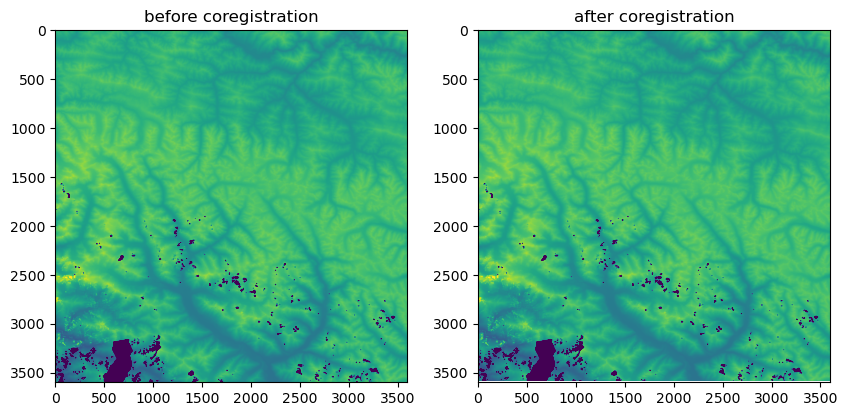

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(dem.data[0], vmax=7000, vmin=0); plt.title('before coregistration')
plt.subplot(1,2,2)
plt.imshow(dem_aligned.data[0], vmax=7000, vmin=0); plt.title('after coregistration')
# writeTiff(dem_aligned.data[0], srtm_info['geotrans'], srtm_info['geosrs'], path_dem_aligned) 
dem_aligned.save(path_dem_aligned)


### **3. Compare the dem difference before and after dems co-registration**

In [7]:
diff_before = srtm - dem             ## before coregistation
diff_after = srtm - dem_aligned      ## after coregistation
inliers_before = diff_before.data[0][mask_img].compressed()
med_before, nmad_before = np.nanmedian(inliers_before), xdem.spatialstats.nmad(inliers_before)
inliers_after = diff_after.data[0][mask_img].compressed()
med_after, nmad_after = np.nanmedian(inliers_after), xdem.spatialstats.nmad(inliers_after)
print(f"Error before: median = {med_before:.2f}; NMAD = {nmad_before:.2f} m")
print(f"Error after: median = {med_after:.2f}; NMAD = {nmad_after:.2f} m")


Error before: median = 1.92; NMAD = 5.83 m
Error after: median = 0.00; NMAD = 5.81 m


Text(0.5, 1.0, 'after co-registration')

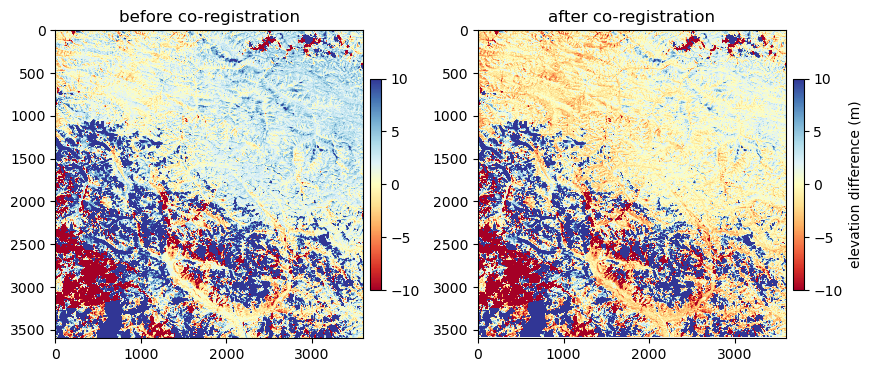

In [8]:
fig1 = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(diff_before.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
plt.title('before co-registration')

plt.subplot(1,2,2)
plt.imshow(diff_after.data[0], vmin=-10, vmax=10, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.02); 
cb.set_label('elevation difference (m)')
plt.title('after co-registration')
